# Using fastai for multi-spectral images - the fastgs library

I am using the [`fastgs` library](https://github.com/restlessronin/fastgs/) which provides multi-spectral / geospatial image support for fastai. The library is currently under active development, and I will attempt to update this notebook as the library evolves.

In [1]:
from __future__ import annotations

In [2]:
# %pip install -Uqq torch torchvision fastgs
# %pip show fastgs
%pip install -Uqq fastgs

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import fastai
import fastgs

print(torch.__version__)
print(torch.cuda.is_available())
print(fastai.__version__)
print(fastgs.__version__)

1.11.0
True
2.7.10
0.0.14


In [4]:
from fastai.vision.all import *

from fastgs.geospatial.sentinel import *
from fastgs.vision.testio import *
from fastgs.vision.data import *
from fastgs.vision.learner import *

In [5]:
import pandas as pd

In [6]:
def read_chn_file(path: str) -> Tensor:
    "Read single channel file into tensor"
    img_arr = np.array(Image.open(path))
    return Tensor(img_arr / 10000)

def read_multichan_files(files: list(str)) -> Tensor:
    "Read individual channel tensor files into a tensor of channels"
    return torch.cat([read_chn_file(path)[None] for path in files])

def read_mask_file(path: str) -> TensorMask:
    """Read ground truth segmentation label files with values from 0 to n."""
    img_arr = np.array(Image.open(path))
    return TensorMask(img_arr)

In [14]:
def id_to_color_name(chn_id: str) -> str:
    if chn_id == "R":
        return "red"
    elif chn_id == "G":
        return "green"
    elif chn_id == "B":
        return "blue"
    elif chn_id == "NIR":
        return "nir"
    elif chn_id == "GT":
        return "gt"
    else:
        assert false
        return None

def get_input_38(stem: str) -> str:
    "Get full input path for stem"
    return "../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/" + stem

def leaf_img_path_38(chn_id: str, tile_id: int) -> str:
    color_name = id_to_color_name(chn_id)
    return f"train_{color_name}/{color_name}_patch_{tile_id}.TIF"

def get_input_95(stem: str) -> str:
    "Get full input path for stem"
    return "../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/" + stem

def leaf_img_path_95(chn_id: str, tile_id: int) -> str:
    color_name = id_to_color_name(chn_id)
    return f"train_{color_name}_additional_to38cloud/{color_name}_{tile_id}.TIF"

def get_channel_filenames(chn_ids, tile_id):
    "Get list of all channel filenames for one tile idx"
    return [get_input_95(leaf_img_path_95(x, tile_id)) for x in chn_ids]

In [15]:
all_raw_bands = MultiSpectral(
    MSDescriptor(["R","G","B","NIR"],[10,10,10,10],[1.0,1.0,1.0,1.0],{}),
    ["R","G","B","NIR"],
    "GT",
    [["R","G","B"],["NIR"]],
    get_channel_filenames,
    read_multichan_files,
    read_mask_file
)

In [10]:
mask_xform_block = TransformBlock(
    type_tfms=[
        partial(MultiSpectral.load_mask, all_raw_bands),
        AddMaskCodes(codes=["not-buildings", "buildings"]),
    ]
)

In [11]:
mc_xform_block = TransformBlock(
    type_tfms=[
        partial(MultiSpectral.load_image, all_raw_bands),
    ]
)

In [12]:
db = DataBlock(
    blocks=(mc_xform_block, mask_xform_block),
    splitter=RandomSplitter(valid_pct=0.2, seed=107),
)

In [17]:
patches = pd.read_csv("../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/training_patches_95-cloud_additional_to_38-cloud.csv")
db.summary(source=patches.name, bs=8)

Setting-up type transforms pipelines
1         patch_1_1_by_1_LC08_L1TP_007054_20170729_20170811_01_T1
2         patch_1_1_by_1_LC08_L1TP_012046_20170801_20170811_01_T1
3         patch_1_1_by_1_LC08_L1TP_013002_20160720_20170323_01_T1
4         patch_1_1_by_1_LC08_L1TP_016035_20161216_20170218_01_T1
                                   ...                           
26296    patch_99_5_by_7_LC08_L1TP_044010_20160220_20170224_01_T1
26297    patch_99_5_by_7_LC08_L1TP_055012_20160421_20170223_01_T1
26298    patch_99_5_by_7_LC08_L1TP_055014_20160320_20170224_01_T1
26299    patch_99_5_by_7_LC08_L1TP_066011_20160520_20170223_01_T1
26300    patch_99_6_by_4_LC08_L1TP_018247_20160520_20170223_01_T1
Name: name, Length: 26301, dtype: object
Found 26301 items
2 datasets of sizes 21041,5260
Setting up Pipeline: partial
Setting up Pipeline: partial -> AddMaskCodes

Building one sample
  Pipeline: partial
    starting from
      patch_427_21_by_7_LC08_L1TP_033022_20161020_20170219_01_T1
    applying pa

In [19]:
dl = db.dataloaders(source=patches.name, bs=8)

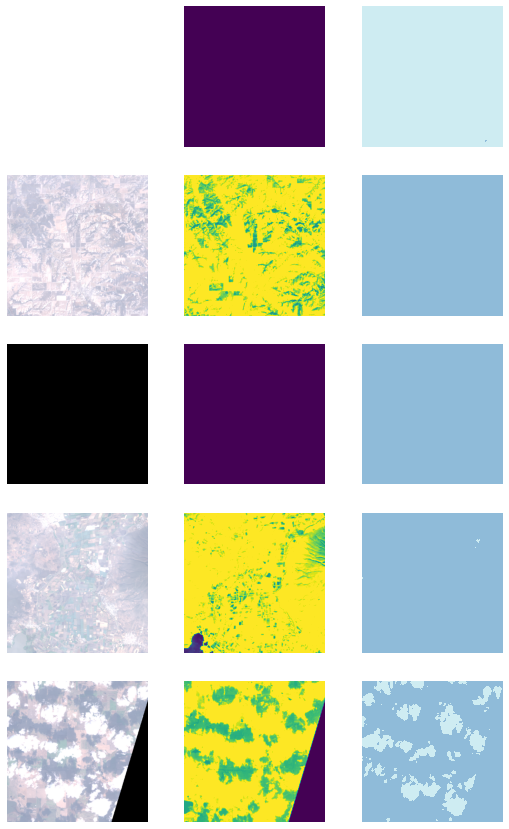

In [20]:
dl.show_batch(max_n=5,mskovl=False)

In [ ]:
learner = unet_learner(
    dl,resnet18,normalize=False,n_in=11,n_out=2,pretrained=True,
    loss_func=CrossEntropyLossFlat(axis=1),metrics=Dice(axis=1)
)

In [ ]:
lrs = learner.lr_find()

In [ ]:
learner.fine_tune(20,lrs.valley)

In [ ]:
learner.show_results(max_n=5,mskovl=False)

In [ ]:
interp = SegmentationInterpretation.from_learner(learner)
interp.plot_top_losses(k=3,mskovl=False)